In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import thor.data as data
import thor.data.dispatch as dispatch
import thor.grid as grid
import thor.track as track
import thor.option as option
import thor.tag as tag
import thor.visualize as visualize

notebook_name = "cpol_demo.ipynb"
__file__ = "/home/ewan/Documents/THOR/examples/cpol_demo.ipynb"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
# Parent directory for saving outputs
base_local = Path("/home/ewan/THOR_output")
start = "2005-11-13T14:00:00"
end = "2005-11-13T19:00:00"

# Create the data_options dictionary
converted_options = {"save": True, "load": False, "parent_converted": None}
cpol_options = data.aura.cpol_data_options(
    start=start, end=end, converted_options=converted_options
)
era5_pl_options = data.era5.data_options(start=start, end=end)
era5_sl_options = data.era5.data_options(
    start=start, end=end, data_format="single-levels"
)
data_options = option.consolidate_options(
    [cpol_options, era5_pl_options, era5_sl_options]
)

dispatch.check_data_options(data_options)
data.option.save_data_options(data_options, filename="cpol_era5")

# Create the grid_options dictionary using the first file in the cpol dataset
filepath = data_options["cpol"]["filepaths"][0]
with xr.open_dataset(filepath) as cpol:
    if converted_options["load"]:
        latitude, longitude = [
            cpol.latitude.values.tolist(),
            cpol.longitude.values.tolist(),
        ]
    else:
        lats = cpol["point_latitude"].isel(z=0).values
        lons = cpol["point_longitude"].isel(z=0).values
        latitude, longitude = grid.new_geographic_grid(lats, lons, 0.025, 0.025)
grid_options = grid.create_options(
    name="geographic", latitude=latitude, longitude=longitude
)
grid.check_options(grid_options)
grid.save_grid_options(grid_options, filename="cpol_geographic")

# Create the tag_options dictionary
era5_pl_tag_options = data.era5.tag_options()
era5_sl_tag_options = data.era5.tag_options(dataset="era5_sl")
tag_options = option.consolidate_options([era5_pl_tag_options, era5_sl_tag_options])
tag.save_tag_options(tag_options, filename="era5")

# Create the track_options dictionary
track_options = option.mcs(dataset="cpol", tags=["era5_pl", "era5_sl"])
option.save_track_options(track_options, filename="cpol_mcs")

# Create the display_options dictionary
visualize_options = {
    obj: visualize.option.runtime_options(
        obj,
        save=True,
        style="presentation",
    )
    for obj in ["cell", "middle_cloud", "anvil", "mcs"]
}
visualize.option.save_display_options(visualize_options, filename="runtime_mcs")

2024-07-02 18:05:11,255 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/data_options/cpol_era5.yaml
2024-07-02 18:05:11,346 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/grid_options/cpol_geographic.yaml
2024-07-02 18:05:11,426 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/tag_options/era5.yaml
2024-07-02 18:05:11,432 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/track_options/cpol_mcs.yaml
2024-07-02 18:05:11,454 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/visualize_options/runtime_mcs.yaml


In [13]:
times = data.aura.generate_cpol_times(data_options["cpol"])
tracks = track.simultaneous_track(
    times,
    data_options,
    grid_options,
    track_options,
    tag_options,
    visualize_options=None,
    output_directory=base_local / "runs/cpol_demo",
)

2024-07-02 18:20:27,914 - thor.track - INFO - Processing 2005-11-13T14:00:09.
2024-07-02 18:20:27,920 - thor.data.aura - DEBUG - Updating cpol dataset for 2005-11-13T14:00:09.
2024-07-02 18:20:27,922 - thor.data.aura - DEBUG - Converting cpol data from twp10cpolgrid150.b2.20051113.140000.nc
2024-07-02 18:20:28,669 - thor.track - DEBUG - Processing hierarchy level 0.
2024-07-02 18:20:28,671 - thor.track - DEBUG - Tracking cell.
2024-07-02 18:20:34,187 - thor.visualize.runtime - DEBUG - Saving mask for cell.
2024-07-02 18:20:56,724 - thor.track - DEBUG - Tracking middle_cloud.
2024-07-02 18:20:56,845 - thor.visualize.runtime - DEBUG - Saving mask for middle_cloud.
2024-07-02 18:20:58,288 - thor.track - DEBUG - Tracking anvil.
2024-07-02 18:20:58,446 - thor.visualize.runtime - DEBUG - Saving mask for anvil.
2024-07-02 18:20:59,484 - thor.track - DEBUG - Processing hierarchy level 1.
2024-07-02 18:20:59,485 - thor.track - DEBUG - Tracking mcs.
2024-07-02 18:20:59,817 - thor.visualize.runti

KeyboardInterrupt: 

In [44]:
cpol = xr.open_dataset(data_options["cpol"]["filepaths"][-2].replace("raw", "converted")).isel(time=0, altitude=6)
gridcell_area = cpol["gridcell_area"]
mask = xr.open_dataset("/home/ewan/THOR_output/runs/cpol_demo/masks/mcs_masks.nc")
mask = mask.isel(time=-2)
cpol_next = xr.open_dataset(data_options["cpol"]["filepaths"][-1].replace("raw", "converted")).isel(time=0, altitude=6)
cpol = cpol["reflectivity"]
cpol_next = cpol_next["reflectivity"]

In [40]:
from thor.object.object import get_object_centre, get_object_area, get_bounding_box, expand_bounding_box, clip_bounding_box
import thor.match.correlate as correlate

In [41]:
obj=1
bounding_box = get_bounding_box(obj, mask["cell_mask"])
# cpol.where(mask['cell_mask'] == obj).plot()

flow_margin = 0.4
grid_spacing = grid_options["geographic_spacing"]
flow_margin_row = int(np.ceil(flow_margin / grid_spacing[0]))
flow_margin_col = int(np.ceil(flow_margin / grid_spacing[1]))
flow_box = bounding_box.copy()
flow_box = expand_bounding_box(flow_box, flow_margin_row, flow_margin_col)
flow_box = clip_bounding_box(flow_box, cpol.shape)
current_grid = cpol_next.copy()
previous_grid = cpol.copy()

box_current = current_grid[
    flow_box["row_min"] : flow_box["row_max"] + 1,
    flow_box["col_min"] : flow_box["col_max"] + 1,
]
box_previous = previous_grid[
    flow_box["row_min"] : flow_box["row_max"] + 1,
    flow_box["col_min"] : flow_box["col_max"] + 1,
]

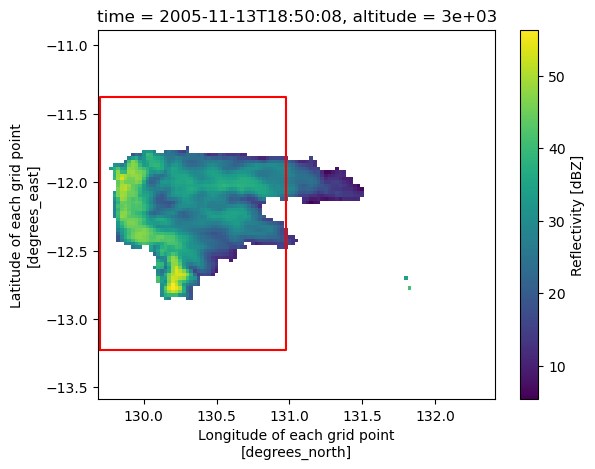

In [42]:
cpol.plot()

box = flow_box

rows = [box["row_min"], box["row_min"], box["row_max"], box["row_max"], box["row_min"]]
cols = [box["col_min"], box["col_max"], box["col_max"], box["col_min"], box["col_min"]]
plt.plot(mask.longitude.values[cols], mask.latitude.values[rows], 'r-')
plt.show()

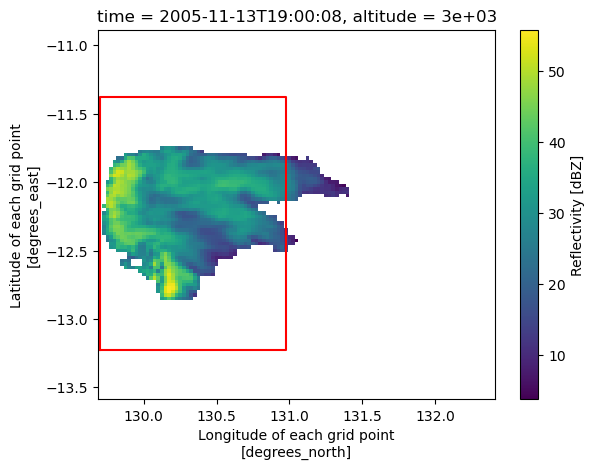

In [28]:
bounding_box = get_bounding_box(obj, mask["cell_mask"])
# cpol.where(mask['cell_mask'] == obj).plot()
cpol_next.plot()

box = flow_box

rows = [box["row_min"], box["row_min"], box["row_max"], box["row_max"], box["row_min"]]
cols = [box["col_min"], box["col_max"], box["col_max"], box["col_min"], box["col_min"]]
plt.plot(mask.longitude.values[cols], mask.latitude.values[rows], 'r-')
plt.show()

In [22]:
box_current = box_current.fillna(0)

In [38]:
correlate.get_flow(box_previous.fillna(0), box_current.fillna(0))

array([-1, -2])

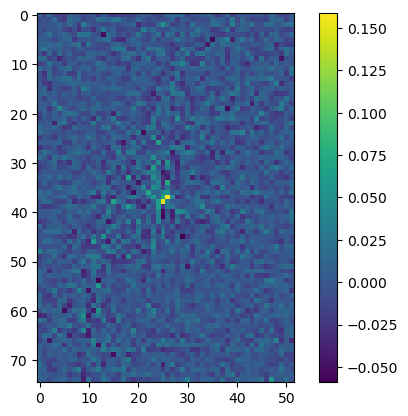

In [37]:
plt.imshow(correlate.get_cross_covariance(box_previous.fillna(0), box_current.fillna(0)))
plt.colorbar()

In [74]:
print(row_inds*(areas/areas.sum()).sum())
print(col_inds*(areas/areas.sum()).sum())
print(areas*(areas/areas.sum()))
# (areas/areas.sum())


[51. 51. 51. 52. 52. 52. 53. 53. 53. 53. 53. 54. 54. 54. 54. 54. 54. 54.
 55. 55. 55. 55. 55. 55. 55. 56. 56. 56. 56. 56. 56. 56. 57. 57. 57. 57.
 57. 58. 58. 58. 58. 58. 59. 59. 59. 59. 59. 60. 60. 60. 60. 60. 61. 61.
 61. 61. 61. 62. 62. 62. 63. 63. 63.]
[81. 82. 83. 81. 82. 83. 81. 82. 83. 84. 85. 81. 82. 83. 84. 85. 86. 87.
 81. 82. 83. 84. 85. 86. 87. 81. 82. 83. 84. 85. 86. 87. 81. 82. 83. 84.
 85. 81. 82. 83. 84. 85. 81. 82. 83. 84. 85. 80. 81. 82. 83. 84. 80. 81.
 82. 83. 84. 82. 83. 84. 82. 83. 84.]
[0.11931952 0.11931952 0.11931952 0.11934162 0.11934162 0.11934162
 0.11936368 0.11936368 0.11936368 0.11936368 0.11936368 0.1193857
 0.1193857  0.1193857  0.1193857  0.1193857  0.1193857  0.1193857
 0.11940767 0.11940767 0.11940767 0.11940767 0.11940767 0.11940767
 0.11940767 0.1194296  0.1194296  0.1194296  0.1194296  0.1194296
 0.1194296  0.1194296  0.11945149 0.11945149 0.11945149 0.11945149
 0.11945149 0.11947334 0.11947334 0.11947334 0.11947334 0.11947334
 0.11949514 0.119495

In [73]:
row_inds.mean()

np.float64(56.80952380952381)

In [72]:
(row_inds*areas).sum()/areas.sum()

np.float64(56.81052875702969)

In [59]:
len(areas)

11704

In [48]:
cpol.latitude.values[0]

np.float64(-13.575000000000001)

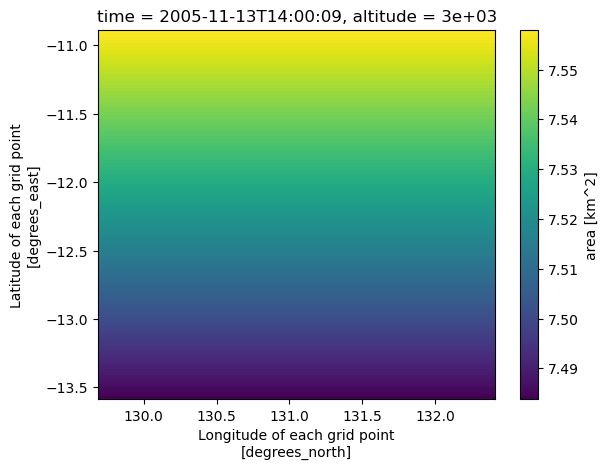

In [9]:
cpol["gridcell_area"].plot()
plt.show()

In [59]:
for var in cpol.data_vars.keys():
    print(var)

reflectivity
cell_area
